In [3]:
import pyshark
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt

In [4]:
pcap_480p = pyshark.FileCapture("youtube_480.pcap")
pcap_720p = pyshark.FileCapture("youtube_720.pcap")
pcap_1080p = pyshark.FileCapture("youtube_1080.pcap")
pcap_2k = pyshark.FileCapture("youtube_2k.pcap")
pcap_4k = pyshark.FileCapture("youtube_4k.pcap")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Question A1

In [5]:
def extract_data(capture):

    # get src_ip
    src_ip = "_"
    for packet in capture:
        if "ip" in packet and "dns" in packet:
            src_ip = packet.ip.src
            break
        elif "ipv6" in packet and "dns" in packet:
            src_ip = packet.ipv6.src
            break

  # extract uplink and downlink packets
    uplink_packs=[]
    downlink_packs=[]
    maxval = 0.0

    for packet in capture:
        if("ip" in packet ):
            if packet.ip.src == src_ip:
                uplink_packs.append(packet)
            if packet.ip.dst == src_ip:
                downlink_packs.append(packet)
        if("ipv6" in packet ):
            if packet.ipv6.src == src_ip:
                uplink_packs.append(packet)
            if packet.ipv6.dst == src_ip:
                downlink_packs.append(packet)

        maxval = max(maxval, float(packet.frame_info.time_relative))

    maxval = round(maxval,0)
    up_pps = {num/10: 0 for num in range(int((maxval + 0.1) * 10))}
    up_kbps = {num/10: 0 for num in range(int((maxval + 0.1) * 10))}
    down_pps = {num/10: 0 for num in range(int((maxval + 0.1) * 10))}
    down_kbps = {num/10: 0 for num in range(int((maxval + 0.1) * 10))}

    #uplink pps and KBps data
    for packet in uplink_packs:
        ts = float(packet.frame_info.time_relative)
        k=round(ts,1)
        if k in up_pps:
            up_pps[k]+=10
        else:
            up_pps[k]=10
        if k in up_kbps:
            up_kbps[k]+=(int(packet.length)/100)
        else:
            up_kbps[k]=int(packet.length)/100

    #downlink pps and KBps data
    for packet in downlink_packs:
        ts = float(packet.frame_info.time_relative)
        k=round(ts,1)
        if k in down_pps:
            down_pps[k]+=10
        else:
            down_pps[k]=10
        if k in down_kbps:
            down_kbps[k]+=(int(packet.length)/100)
        else:
            down_kbps[k]=int(packet.length)/100

    return up_pps,up_kbps,down_pps,down_kbps


In [6]:
up_pps_480p,up_kbps_480p,down_pps_480p,down_kbps_480p = extract_data(pcap_480p)
up_pps_720p,up_kbps_720p,down_pps_720p,down_kbps_720p = extract_data(pcap_720p)
up_pps_1080p,up_kbps_1080p,down_pps_1080p,down_kbps_1080p = extract_data(pcap_1080p)
up_pps_2k,up_kbps_2k,down_pps_2k,down_kbps_2k = extract_data(pcap_2k)
up_pps_4k,up_kbps_4k,down_pps_4k,down_kbps_4k = extract_data(pcap_4k)

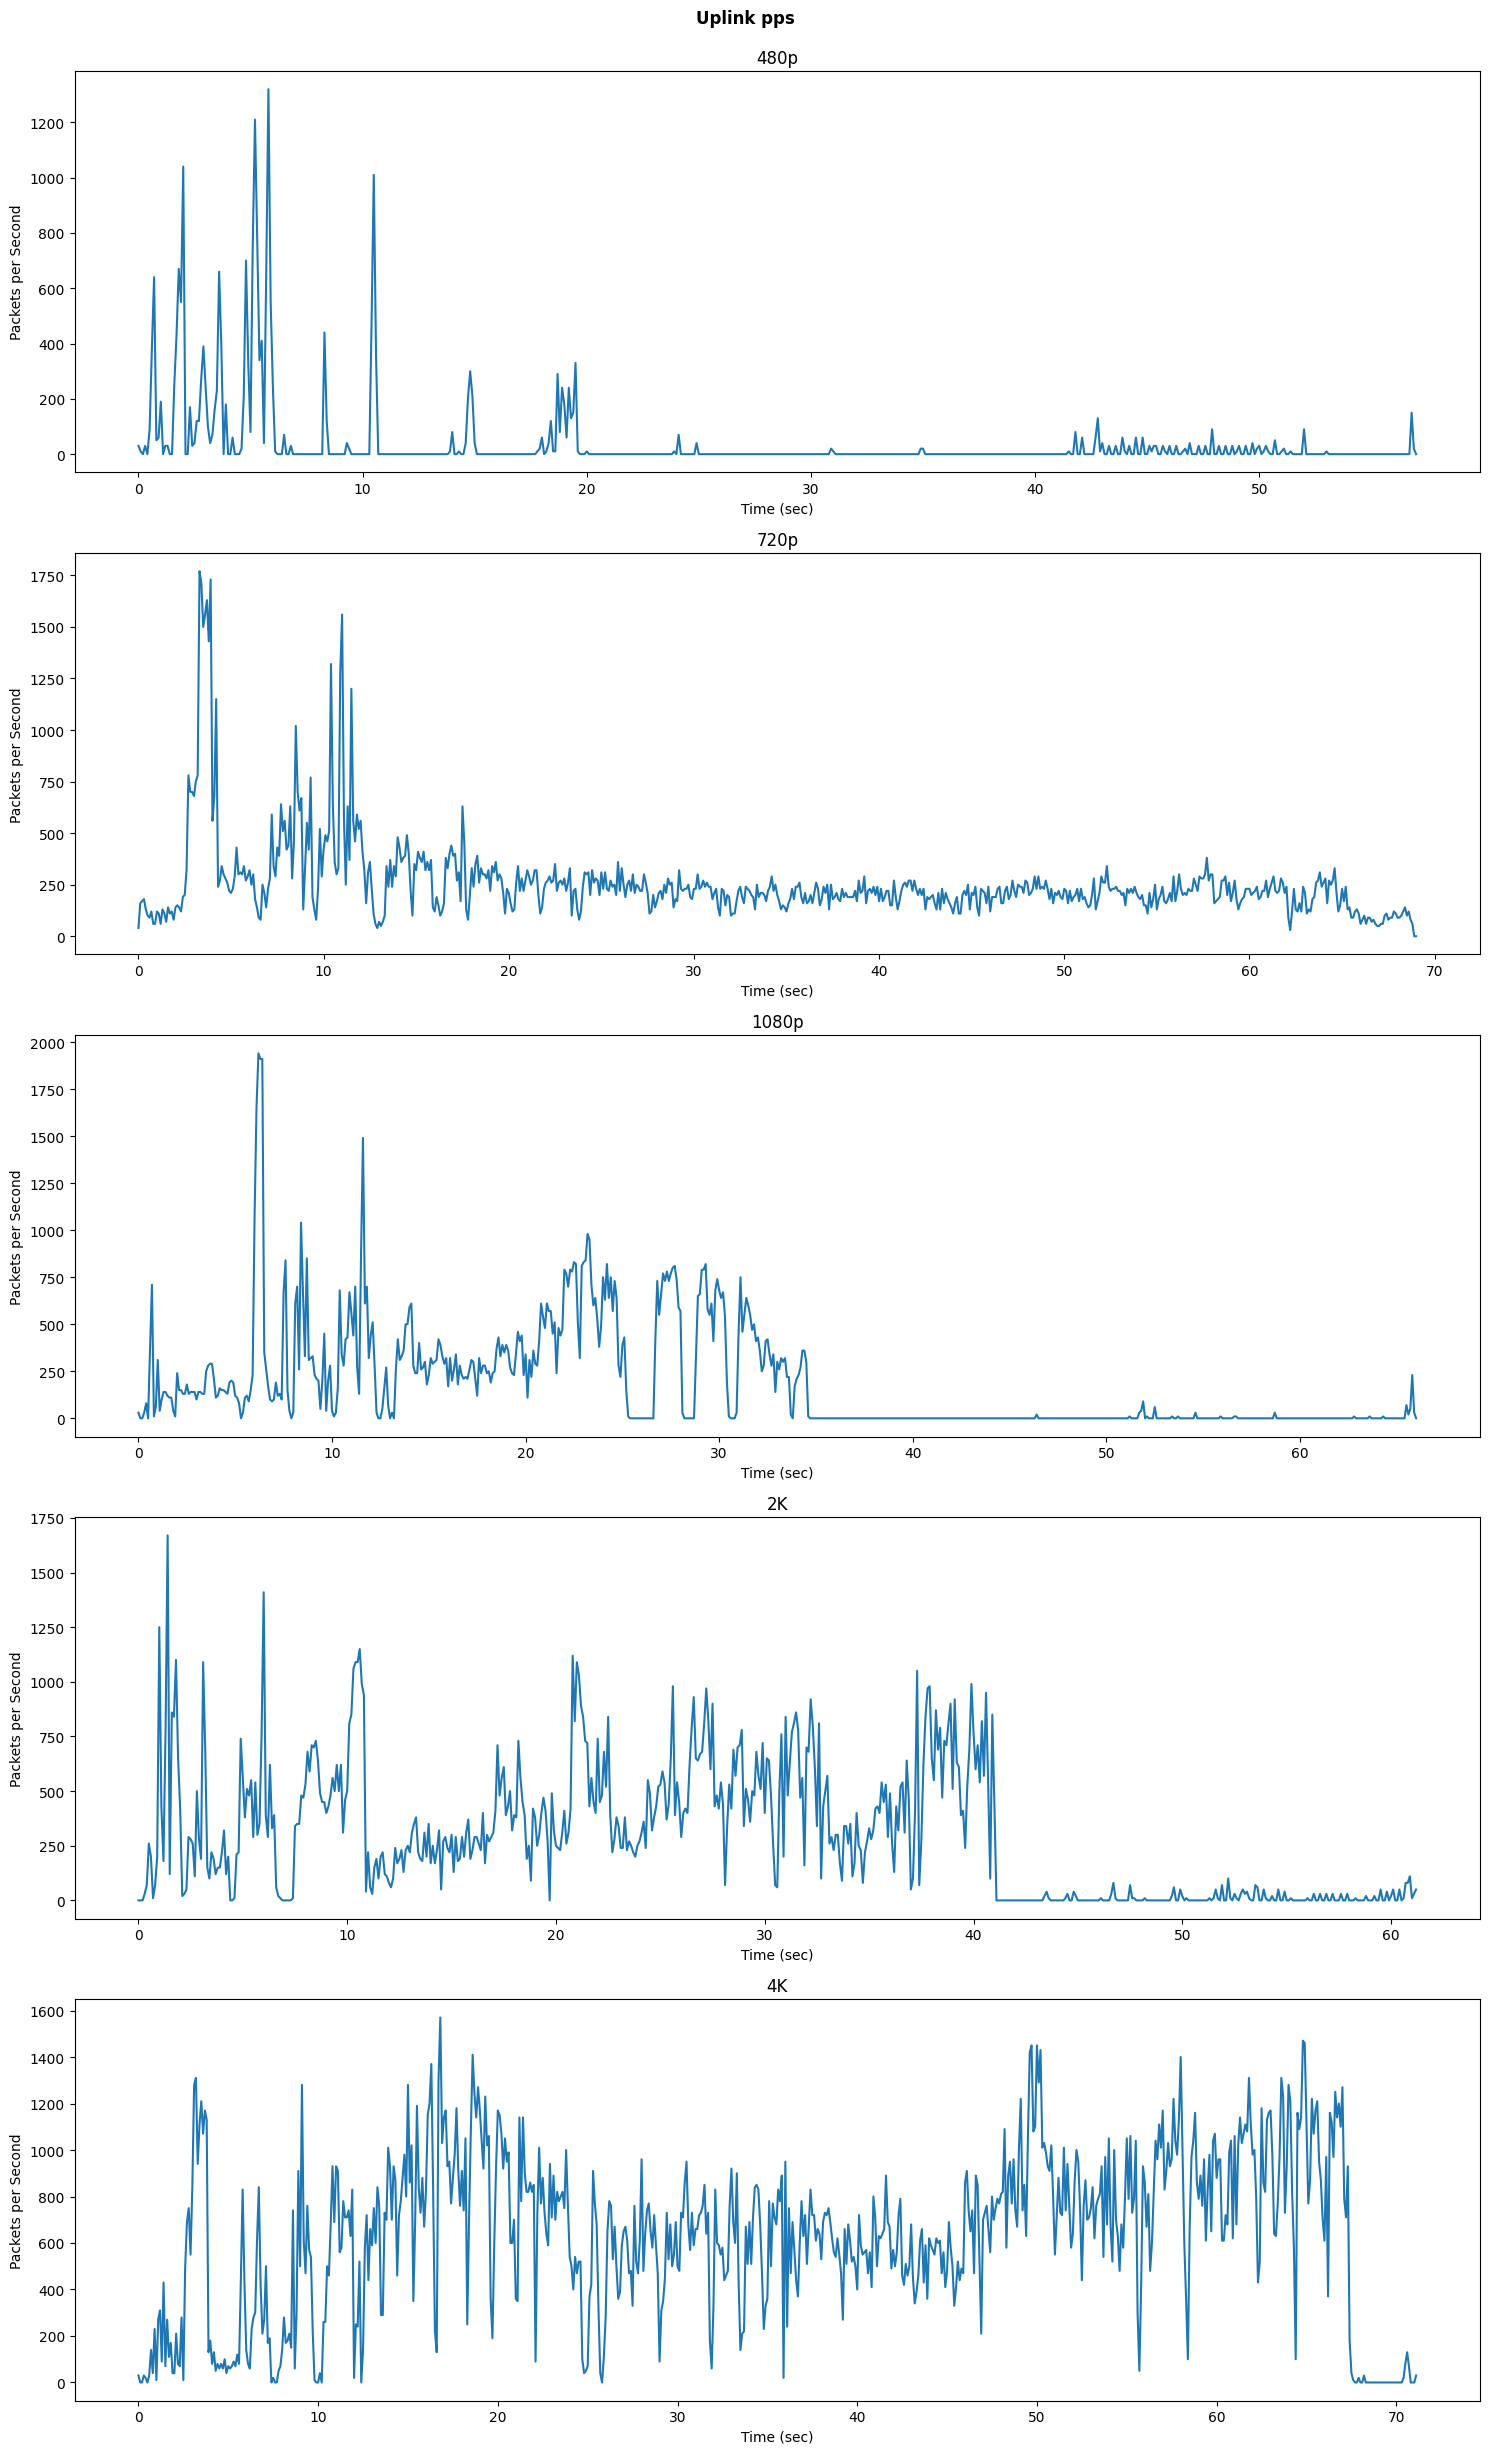

In [7]:
#plotting uplink pps

fig, axs = plt.subplots(5, 1, figsize=(15, 25))

for ax, data, name in zip(axs, [up_pps_480p, up_pps_720p, up_pps_1080p, up_pps_2k, up_pps_4k], ['480p', '720p', '1080p', '2K', '4K']):
    ax.plot(list(data.keys()), list(data.values()))
    ax.set_title(name)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Packets per Second')

fig.suptitle('Uplink pps\n\n',fontweight='bold')

plt.tight_layout()
plt.show()

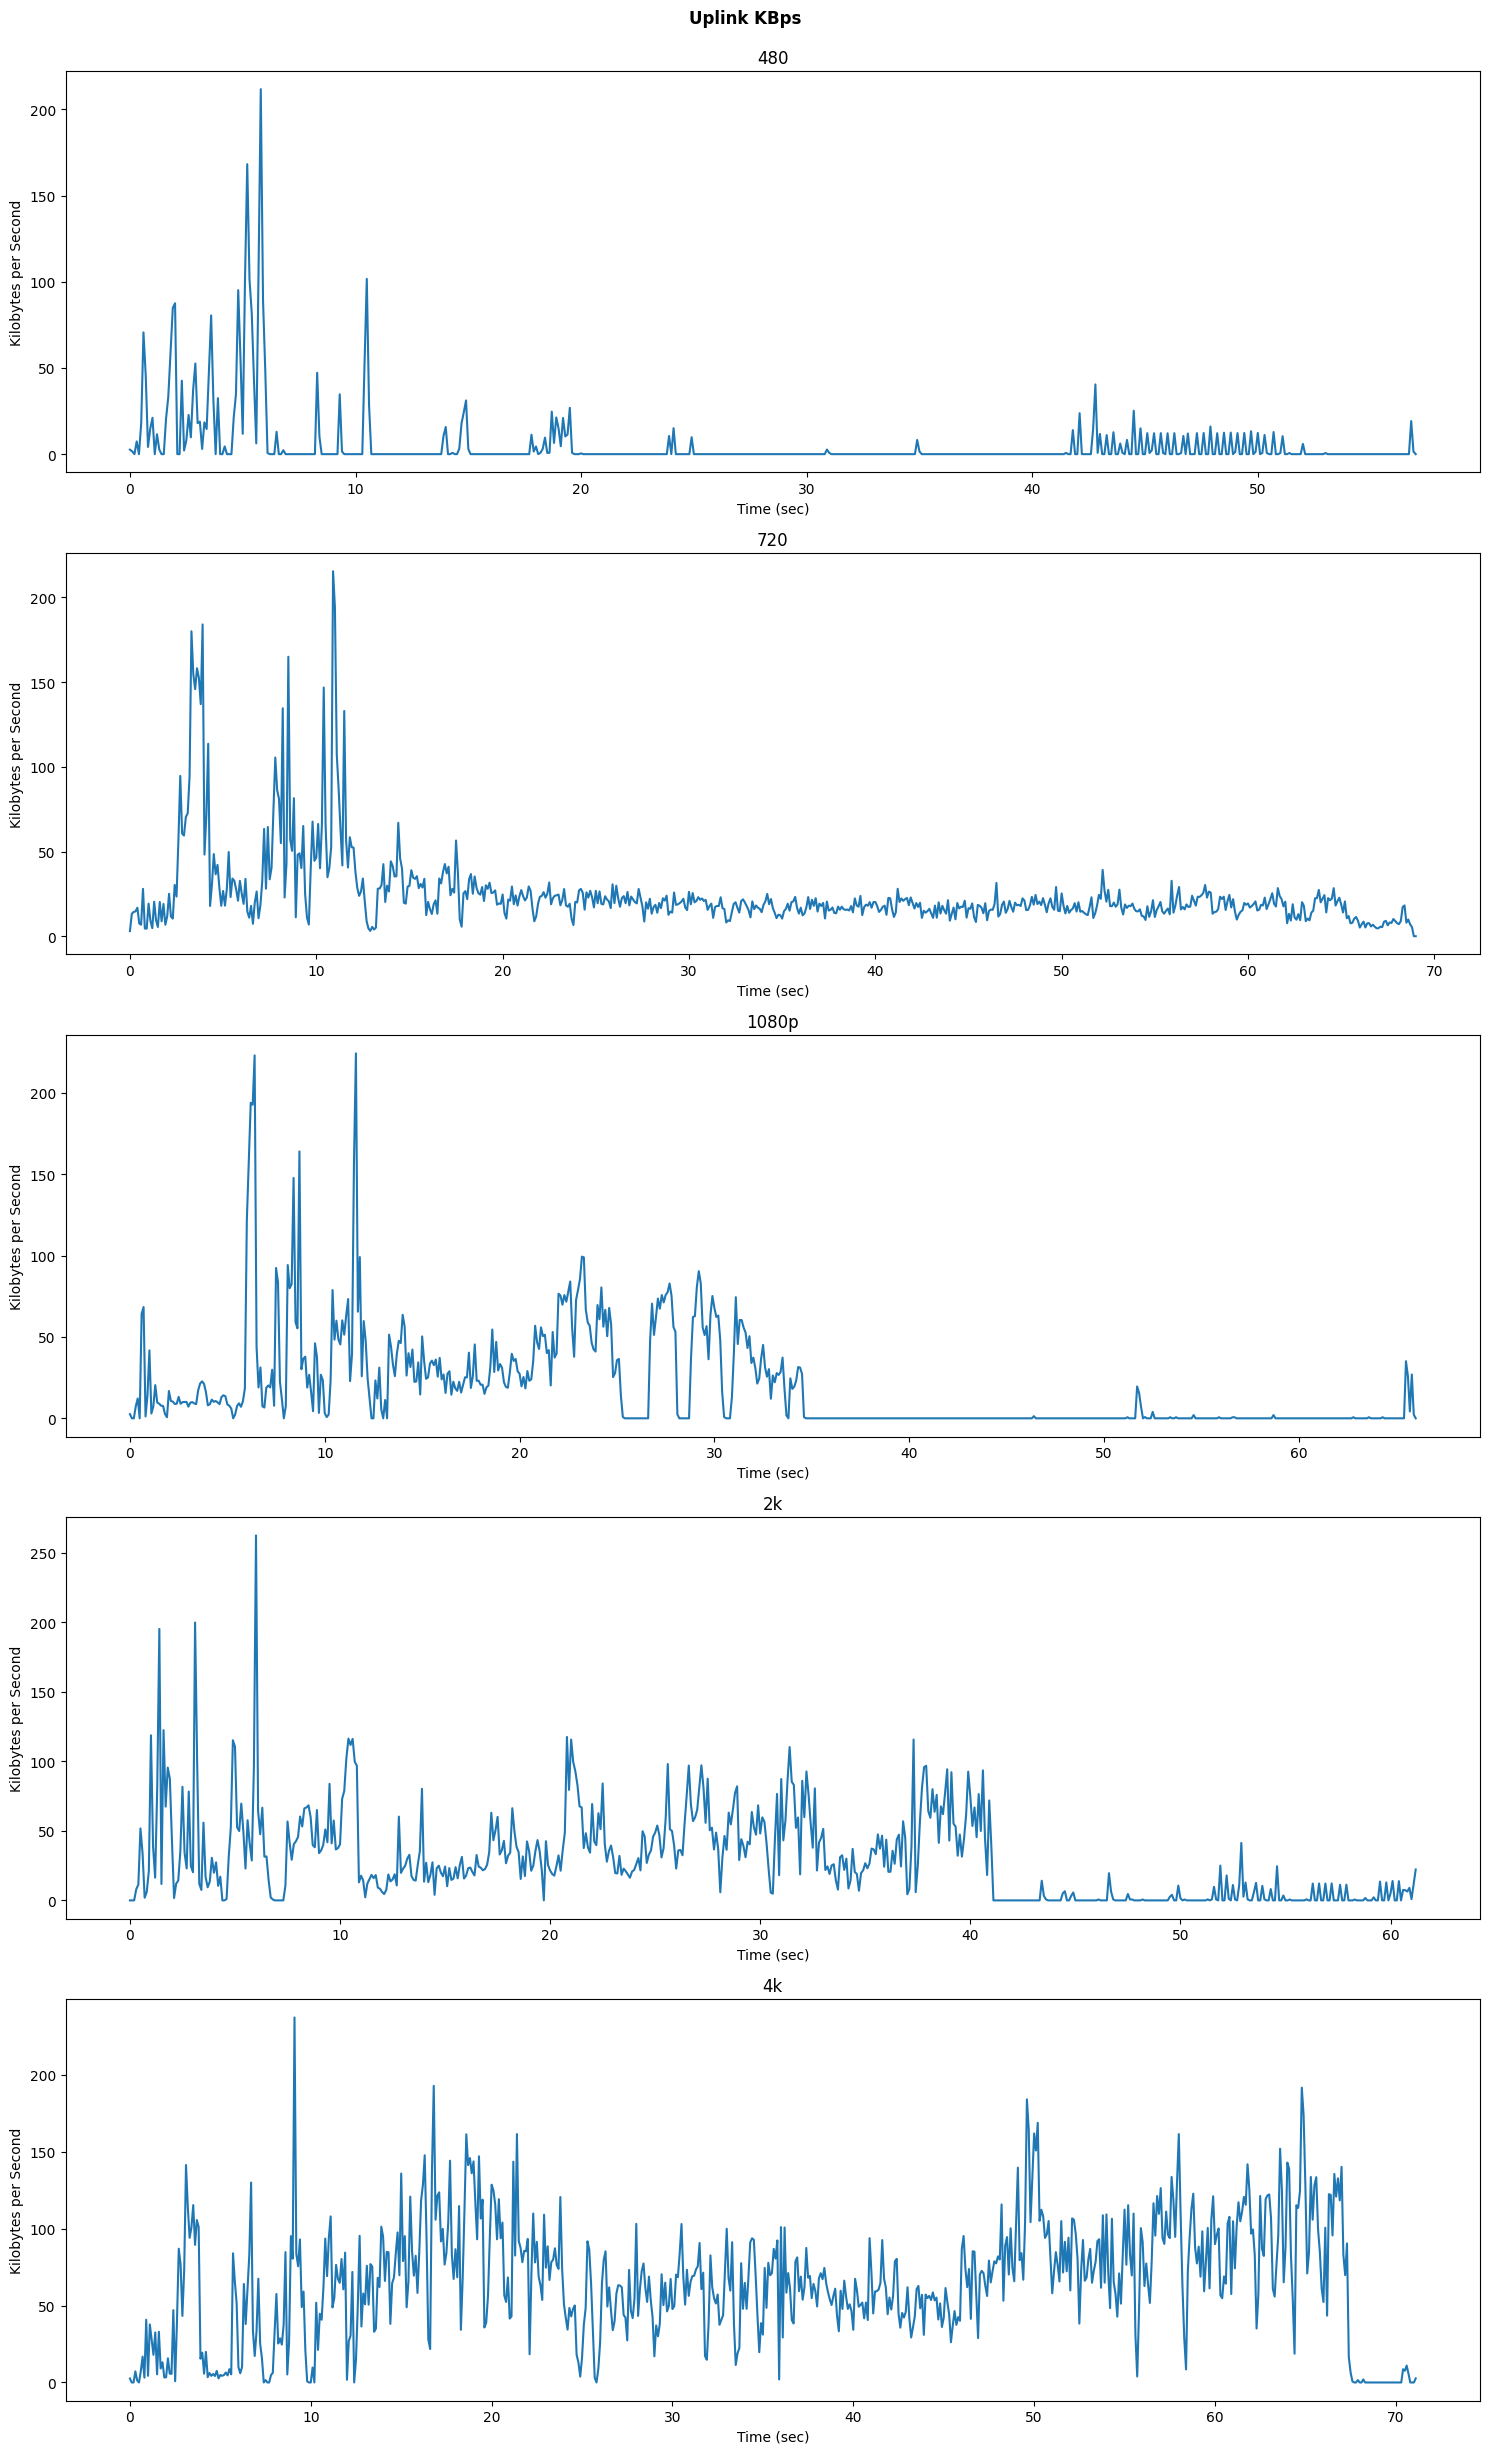

In [8]:
#plotting uplink kbps

fig, axs = plt.subplots(5, 1, figsize=(15, 25))

for ax, data, name in zip(axs, [up_kbps_480p, up_kbps_720p, up_kbps_1080p, up_kbps_2k, up_kbps_4k], ['480', '720', '1080p', '2k', '4k']):
    ax.plot(list(data.keys()), list(data.values()))
    ax.set_title(name)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Kilobytes per Second')

fig.suptitle('Uplink KBps\n\n',fontweight='bold')

plt.tight_layout()
plt.show()

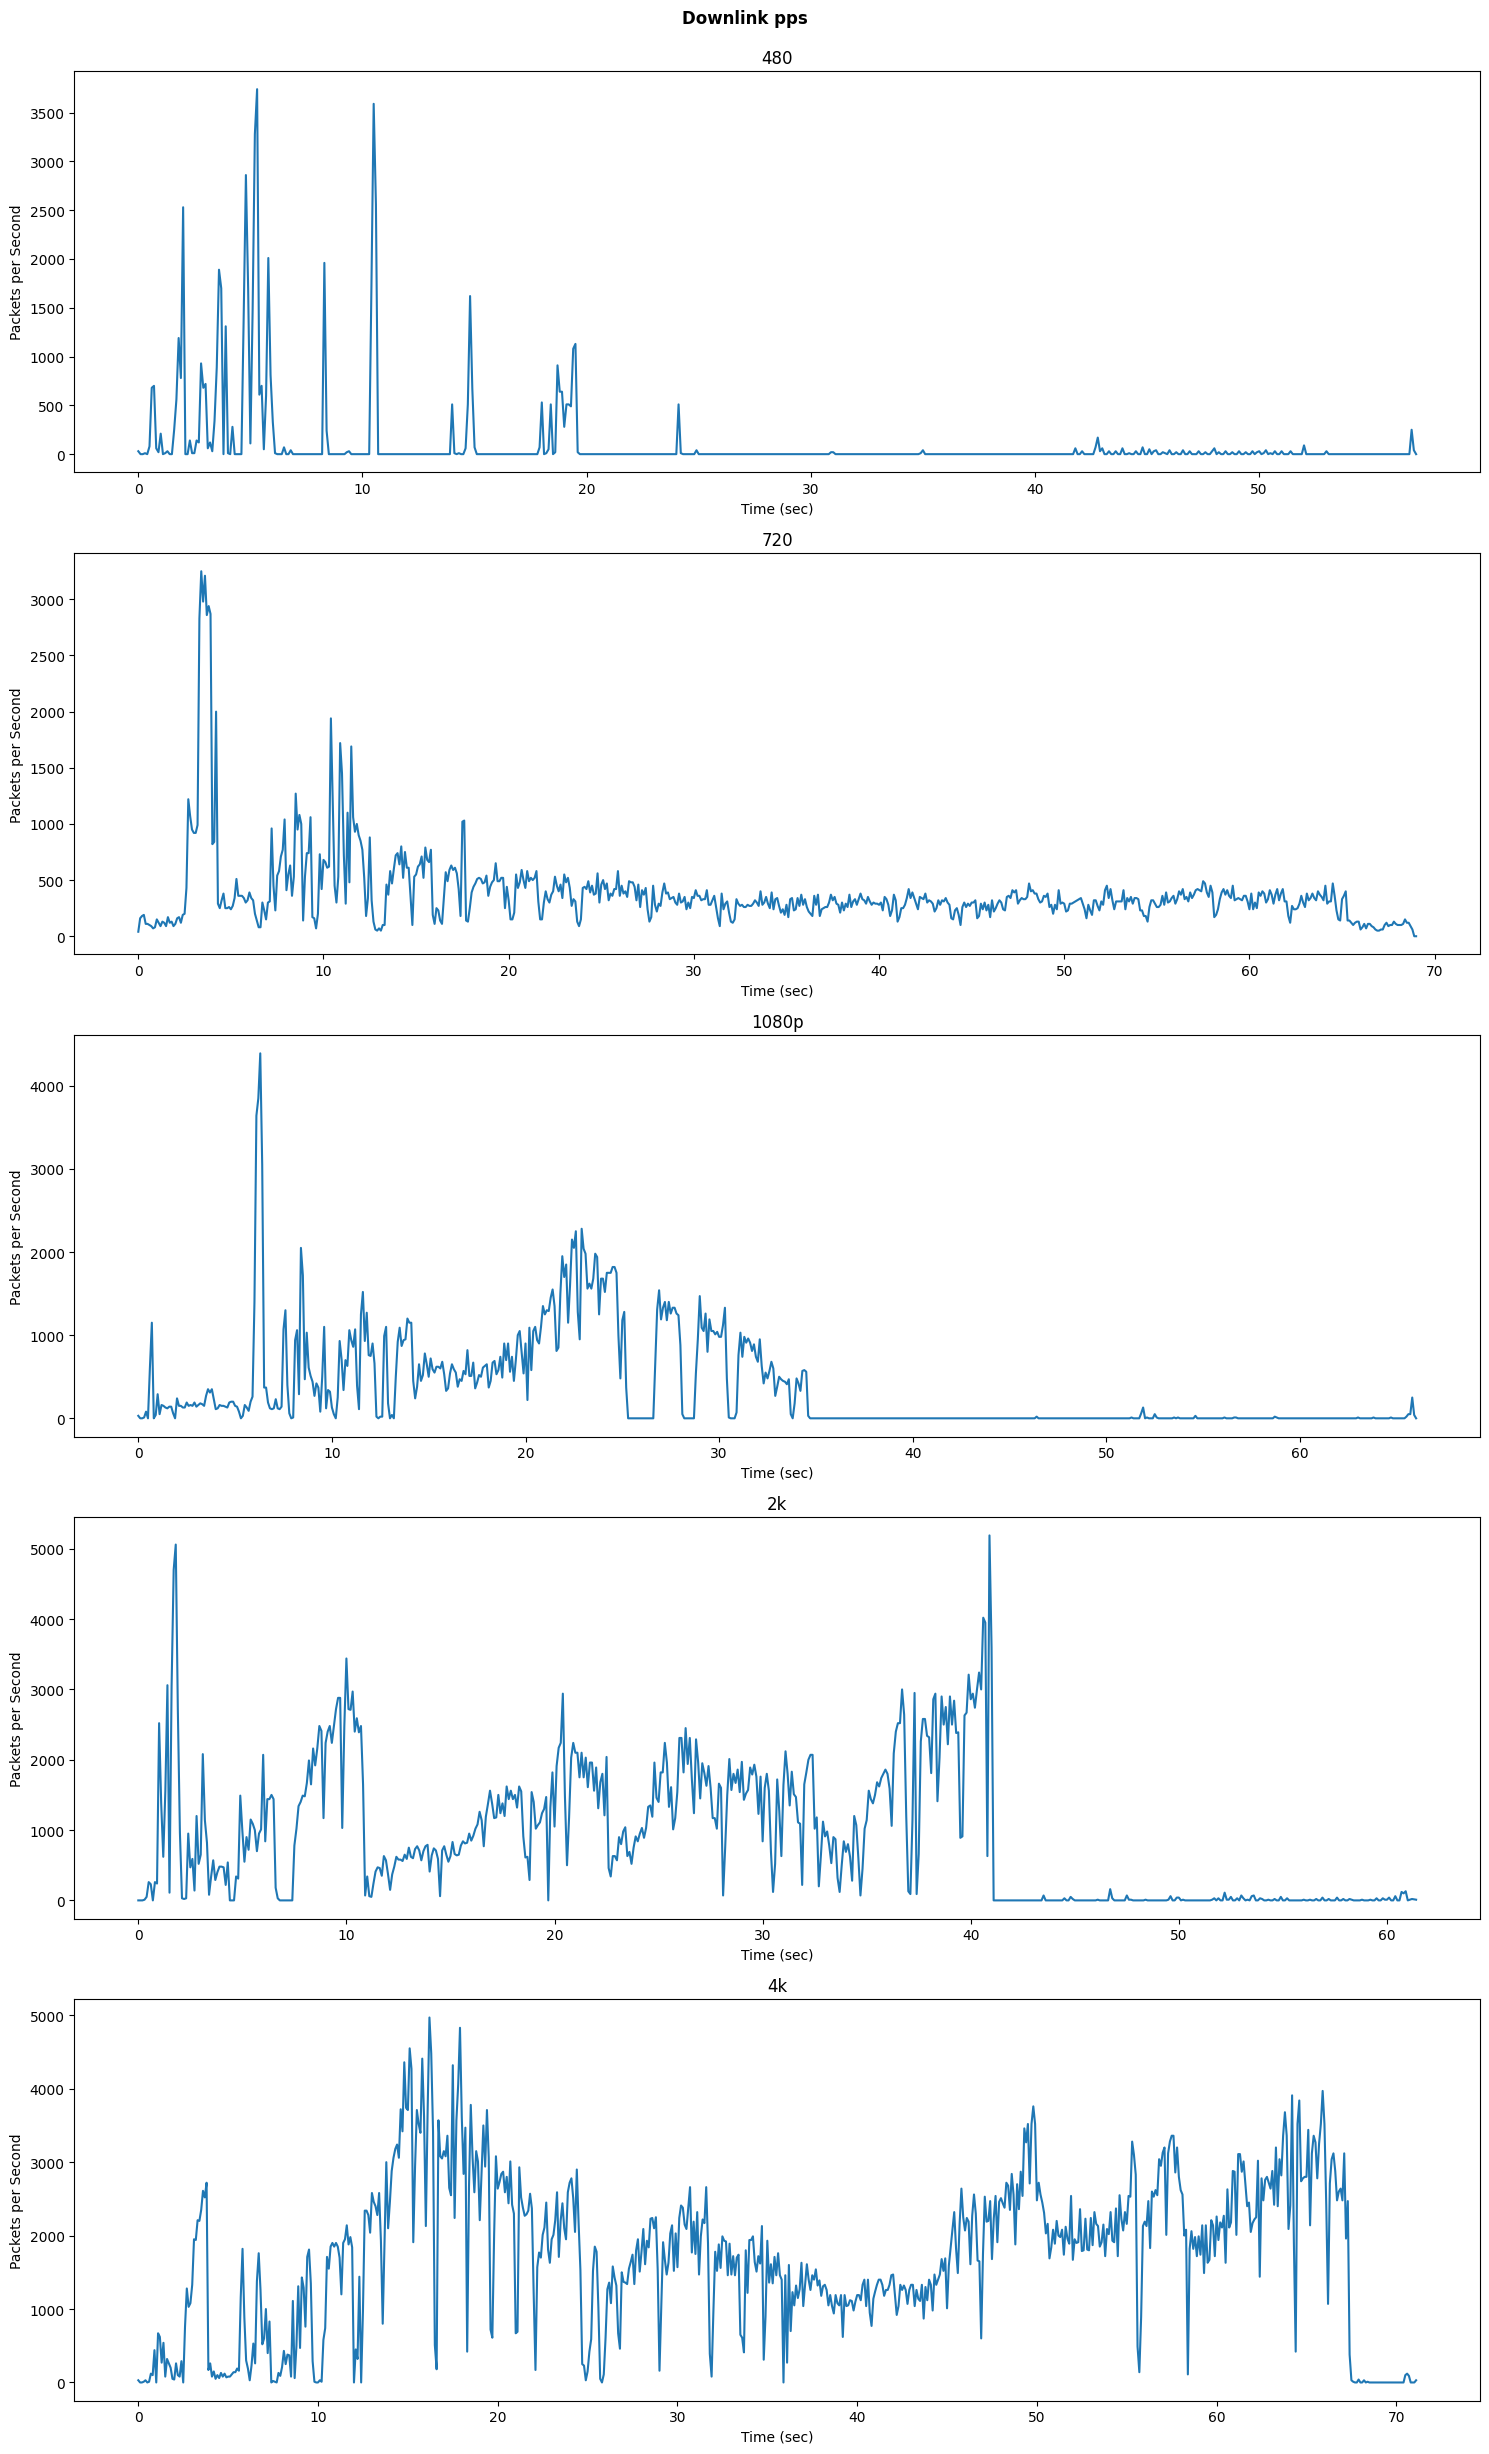

In [9]:
#plotting downlink pps

fig, axs = plt.subplots(5, 1, figsize=(15, 25))

for ax, data, name in zip(axs, [down_pps_480p, down_pps_720p, down_pps_1080p, down_pps_2k, down_pps_4k], ['480', '720', '1080p', '2k', '4k']):
    ax.plot(list(data.keys()), list(data.values()))
    ax.set_title(name)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Packets per Second')

fig.suptitle('Downlink pps\n\n',fontweight='bold')

plt.tight_layout()
plt.show()

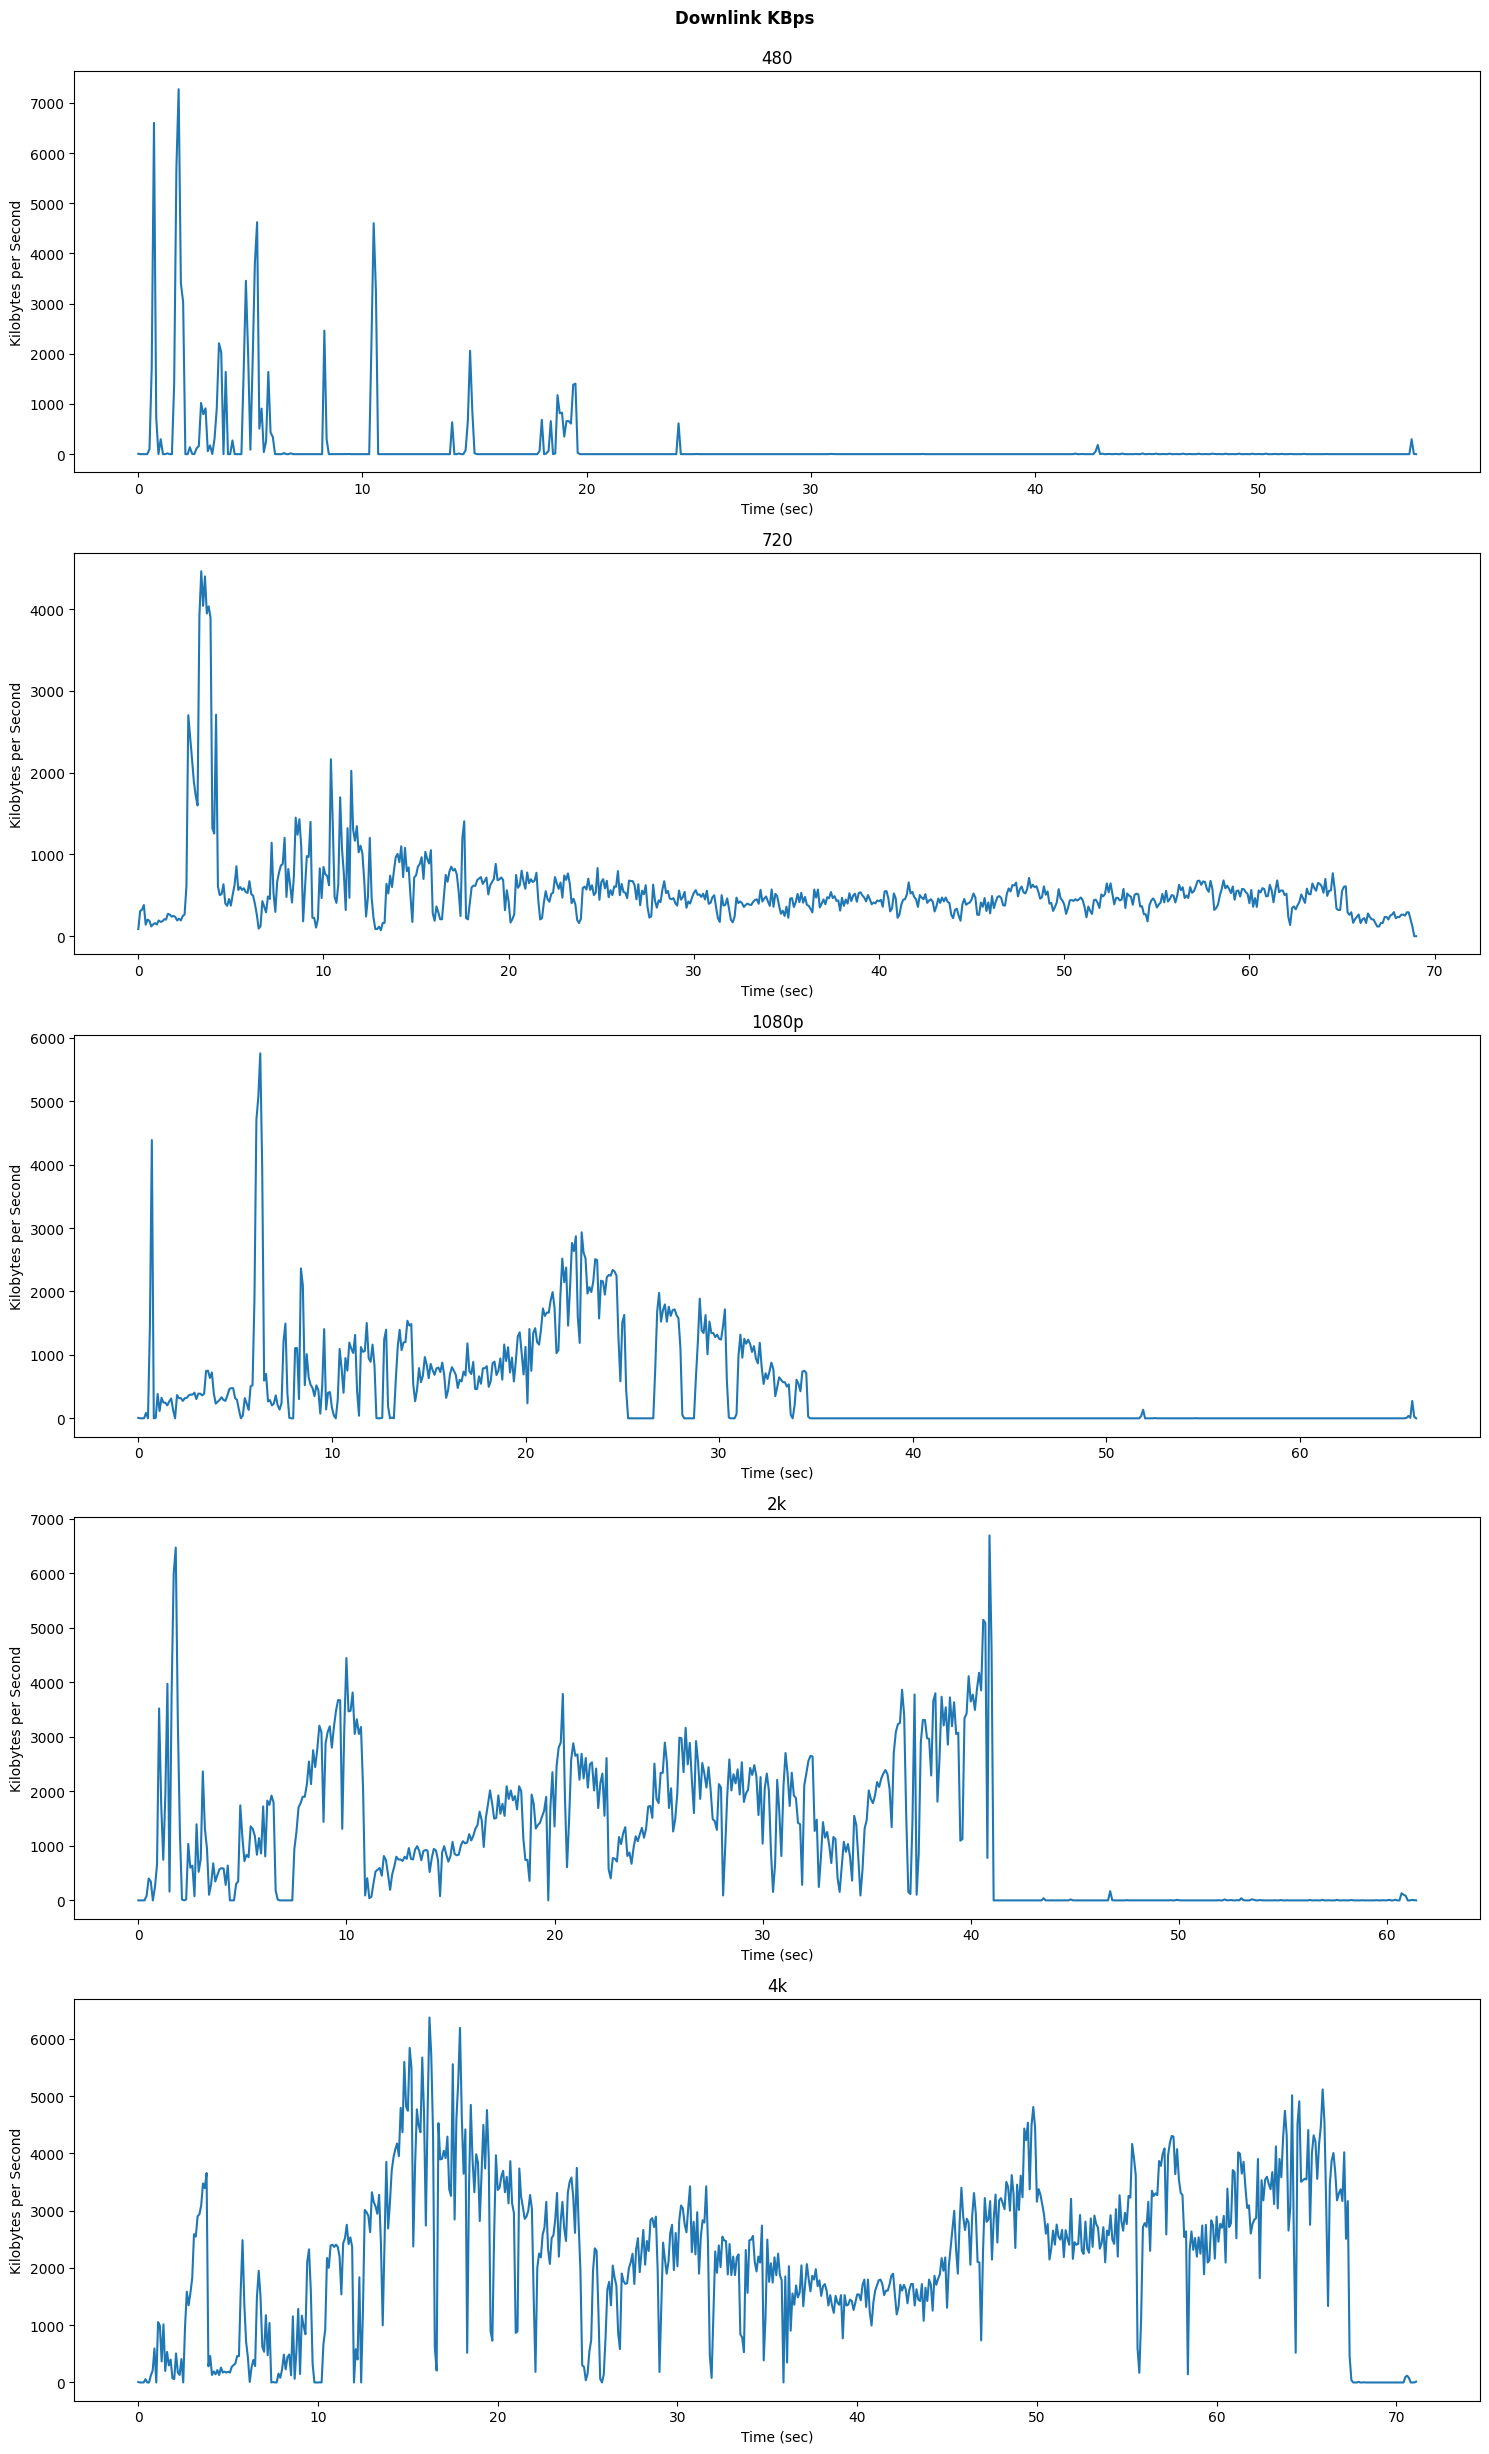

In [10]:
#plotting downlink kbps

fig, axs = plt.subplots(5, 1, figsize=(15, 25))

for ax, data, name in zip(axs, [down_kbps_480p, down_kbps_720p, down_kbps_1080p, down_kbps_2k, down_kbps_4k], ['480', '720', '1080p', '2k', '4k']):
    ax.plot(list(data.keys()), list(data.values()))
    ax.set_title(name)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Kilobytes per Second')

fig.suptitle('Downlink KBps\n\n',fontweight='bold')

plt.tight_layout()
plt.show()

# Question A2)

In [11]:
threshold = 100

In [12]:
def fraction_burst_slots(downlink_dict, resolution):
  burst_slots = 0
  observed_slots = len(downlink_dict)
  for item in downlink_dict.keys():
    if downlink_dict[item]/10>=threshold:
      burst_slots+=1

  print("fraction of burst slots for " + resolution + " = "  + str(burst_slots/observed_slots))

In [13]:
fraction_burst_slots(down_pps_480p, "480p")
fraction_burst_slots(down_pps_720p, "720p")
fraction_burst_slots(down_pps_1080p, "1080p")
fraction_burst_slots(down_pps_2k, "2K")
fraction_burst_slots(down_pps_4k, "4K")

fraction of burst slots for 480p = 0.03327495621716287
fraction of burst slots for 720p = 0.0361794500723589
fraction of burst slots for 1080p = 0.13767019667170954
fraction of burst slots for 2K = 0.4006514657980456
fraction of burst slots for 4K = 0.7612359550561798


# Question B

In [14]:
import pyshark
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt

In [15]:
cap_deccan = pyshark.FileCapture("deccan.pcap")
cap_jagran = pyshark.FileCapture("jagran.pcap")
cap_mit = pyshark.FileCapture("mit.pcap")
cap_sinu = pyshark.FileCapture("sinu.pcap")
cap_usach = pyshark.FileCapture("usach.pcap")

In [16]:
def dns_time(capture):
    dns_id = ''
    dns_start = 0
    dns_end = 0
    i = 0
    while True:
        packet = capture[i]
        if "DNS" in packet:
            dns_id = packet.dns.id
            dns_start = float(packet.frame_info.time_relative)
            break
        i += 1

    while True:
        i += 1
        packet = capture[i]
        if "DNS" in packet and packet.dns.id==dns_id:
            dns_end = float(packet.frame_info.time_relative)
            break

    return dns_end - dns_start
print("DNS Query times")
print("Deccan : "+ str(dns_time(cap_deccan)) + "s")
print("Jagran : "+ str(dns_time(cap_jagran)) + "s")
print("MIT    : "+ str(dns_time(cap_mit))+ "s")
print("Usach  : "+ str(dns_time(cap_usach))+ "s")
print("Sinu   : "+ str(dns_time(cap_sinu))+ "s")

DNS Query times
Deccan : 0.558804s
Jagran : 0.653601s
MIT    : 0.455497s
Usach  : 1.096968s
Sinu   : 1.109484s


# Insights


* We observe usach and sinu have higher DNS query times in accordance with their geographical distances and lower popularity (meaning it's probably not DNS cached).
  
* Even though MIT's website is based in the USA, it has a relatively lower DNS time possibly due to DNS caching due to many people accessing it.



In [17]:
def ttfb(capture):
    time_in = 0
    time_out = 0

    i = 0
    while True:
        packet = capture[i]
        if "DNS" in packet:
            time_in = float(packet.frame_info.time_relative)
            break
        i += 1

    rec_server_hello = 0
    while True:
        i += 1
        packet = capture[i]
        if "tls" in packet and hasattr(packet.tls,"handshake_type") and packet.tls.handshake_type=='2':
          rec_server_hello=1

        if rec_server_hello==1 and "tls" in packet and  hasattr(packet.tls,"app_data"):
            time_out = float(packet.frame_info.time_relative)
            break
    return time_out - time_in

print("TTFB (Time to first byte)")
print("TTFB for Deccan = "+ str(ttfb(cap_deccan))+ "s")
print("TTFB for Jagran = "+ str(ttfb(cap_jagran))+ "s")
print("TTFB for MIT    = "+ str(ttfb(cap_mit))+ "s")
print("TTFB for Usach = "+ str(ttfb(cap_usach))+ "s")
print("TTFB for Sinu   = "+ str(ttfb(cap_sinu))+ "s")

TTFB (Time to first byte)
TTFB for Deccan = 0.871187s
TTFB for Jagran = 1.09323s
TTFB for MIT    = 0.561762s
TTFB for Usach = 2.228492s
TTFB for Sinu   = 1.807436s


Cumulative plots


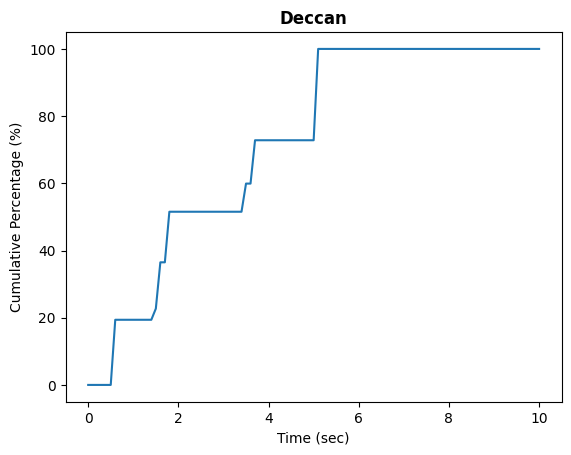

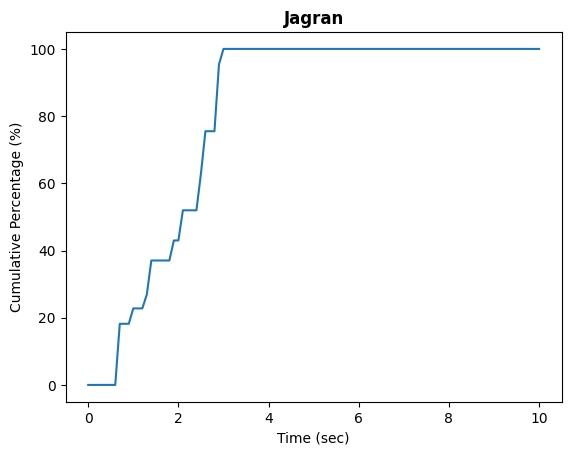

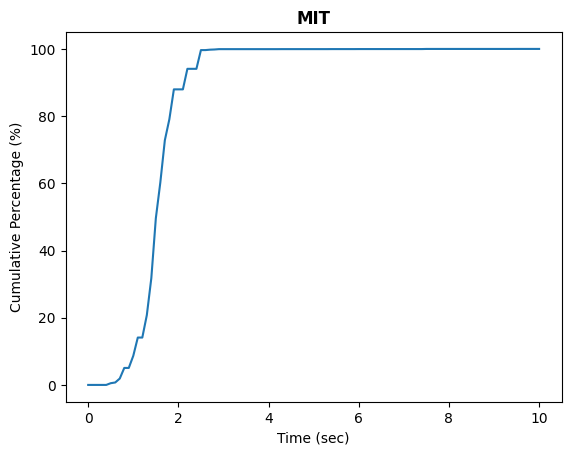

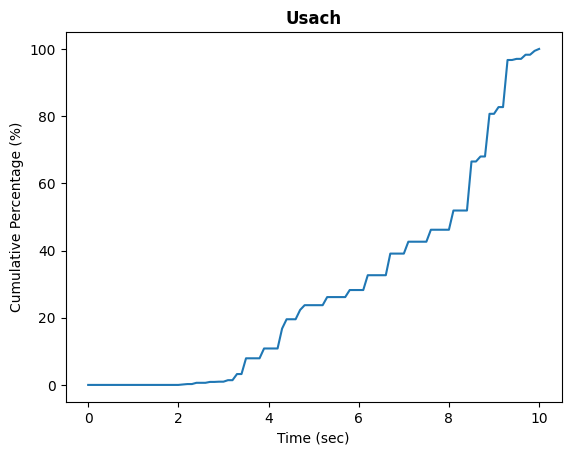

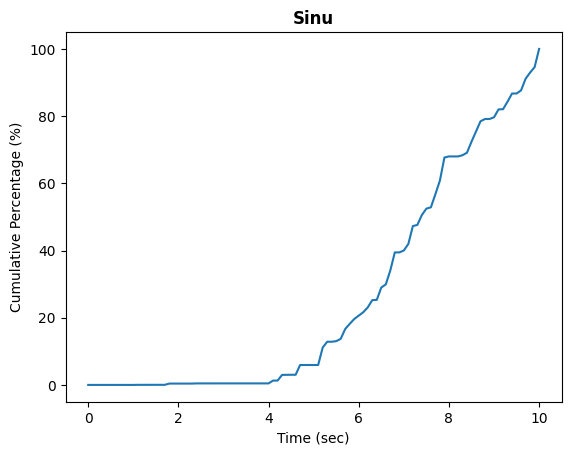

In [20]:
def cum_plot(capture,name):
    src_ip = "_"
    i=0
    for packet in capture:
        i+=1
        if "dns" in packet and "ip" in packet :
            src_ip = packet.ip.src
            break
        elif "dns" in packet and "ipv6" in packet:
            src_ip = packet.ipv6.src
            break

    downlink_packs=[]
    for packet in capture:
        if("ip" in packet ):
            if packet.ip.dst == src_ip:
                downlink_packs.append(packet)
        if("ipv6" in packet ):
            if packet.ipv6.dst == src_ip:
                downlink_packs.append(packet)
    maxval = 10
    plot_kbps = {num/10: 0 for num in range(int((maxval+0.1)*10))}

    for packet in downlink_packs:
        ts = float(packet.frame_info.time_relative)
        k=round(ts,1)
        if(k<10.1):
            plot_kbps[k]+=(int(packet.length)/100)

    cumulative_sum = 0
    for key in sorted(plot_kbps.keys()):
        cumulative_sum += plot_kbps[key]
        plot_kbps[key] = cumulative_sum

    total_bytes = plot_kbps[10.0]

    for key in sorted(plot_kbps.keys()):
        plot_kbps[key] = ((plot_kbps[key]*100)/total_bytes)

    xx = list(plot_kbps.keys())
    yy = list(plot_kbps.values())
    plt.plot(xx, yy, linestyle='-')
    plt.xlabel('Time (sec)')
    plt.ylabel('Cumulative Percentage (%)')
    plt.title(name,fontweight='bold')
    plt.show()

print("Cumulative plots")

cum_plot(cap_deccan,"Deccan")
cum_plot(cap_jagran,"Jagran")
cum_plot(cap_mit,"MIT")
cum_plot(cap_usach,"Usach")
cum_plot(cap_sinu,"Sinu")